In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from bokeh.plotting import figure, output_file, show
import bokeh.palettes
from bokeh.models import (ColumnDataSource, GeoJSONDataSource, HoverTool, LogColorMapper, ColorBar, BasicTicker, BasicTickFormatter)
from bokeh.layouts import row
from bokeh.io import output_notebook
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

C:\Users\Sarah\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
### Time Series Data ### 
pvdf_time = pd.read_pickle('solar_ts.pkl')

In [4]:
### Map Data ###
counties = pd.read_pickle('county_map.pkl')
def state_data_source(data, statename):
    new = data[data.state_name == statename]
    d = GeoJSONDataSource(geojson=new.to_json())
    return d

> # Solar Installations in the United States
***
Sarah Unbehaun <br>
May 2018

In [5]:
county_simple = counties[['name', 'state_name', 'geometry', 'installs']]
county_simple['install_log'] = np.log(county_simple.installs)

C:\Users\Sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


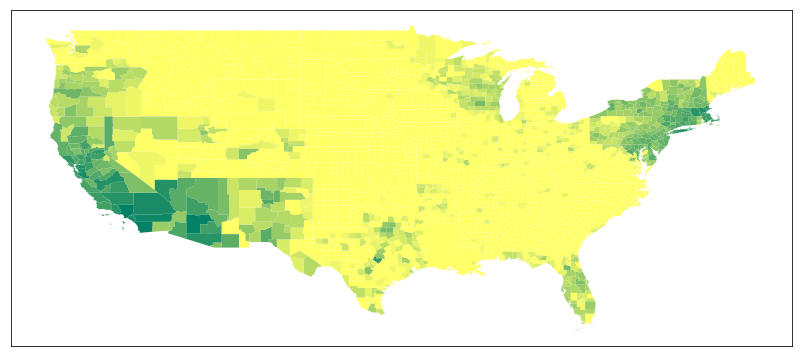

In [45]:
us = county_simple.plot(column='install_log', cmap='summer_r', figsize=(14,10))
us.axes.get_xaxis().set_visible(False)
us.axes.get_yaxis().set_visible(False)
us_plot = us.get_figure()

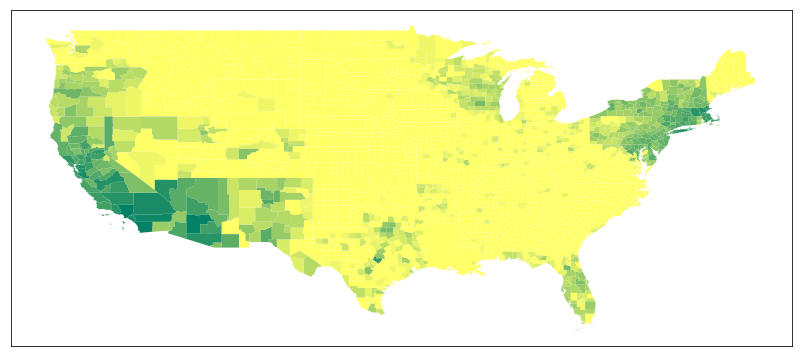

In [46]:
us_plot

# The Data
### Data by county on:
*  Solar installations (NREL Open PV)
*  Direct normal irradiation, PV-suitable small buildings (NSRDB)
*  Electricity prices and utility territories (EIA)
*  Population and median income (Census)
*  2004-2012 presidential elections (USGS, via Hello Word Data) <br>


## Feature Importance
### Random Forest regression predicting solar installations in a county

Top predictors:
*  Population 
*  Number of small buildings
*  Direct Normal Irradiance (DNI)
*  Average cost per watt 
***

Other predictors:
*  Median Income
*  Percent democratic votes, 2004, 2008 and 2012
*  Electricity price
*  Area in square miles
*  Percent of small buildings suitable for solar

In [25]:
### County Map ###
cali = state_data_source(counties, 'California')
palette = bokeh.palettes.brewer['Greens'][8]
palette.reverse()
color_mapper = bokeh.models.LogColorMapper(palette=palette, low=100., high=20000.)
hover = HoverTool(tooltips =[
    ('County', '@name'),
    ('PV Installations', '@installs{0,0}'),
    ('Census 2010', '@census2010{0,0}'),
    ('Small buildings', '@nbld{0,0}'), 
    ('Cost per watt', '@rl_cost_per_watt{1.11}'),
    ('Direct Normal Irradiance', '@dni{1.1}'),
    ('2004 % Democratic vote', '@pct_dem_2004{1.1}')
])

c = figure(tools=[hover], title="California: Installations")
c.patches(xs='xs', ys='ys', fill_alpha=0.7, 
          fill_color={'field': 'installs', 'transform': color_mapper},
          line_color='gray', line_width=0.5, source=cali)
c.grid.grid_line_color = None
c.xaxis.visible = False
c.yaxis.visible = False
color_bar = ColorBar(color_mapper=color_mapper, ticker = BasicTicker(), label_standoff=12, 
                     border_line_color=None, location=(0,0), formatter = BasicTickFormatter())
c.add_layout(color_bar, 'right')

### Time Series ###
ca = pvdf_time[pvdf_time.state=='CA']
ca_df = ca.groupby(pd.Grouper(freq="M")
                   ).agg({'type':'count', 'rl_cost_per_watt':'mean'}).rename(
    columns= {'type':'counts','rl_cost_per_watt':'rl_cpw'})
ca_y = np.log(ca_df.counts)
ca_model = statsmodels.tsa.statespace.SARIMAX(endog=ca_y, order = (0, 1, 1), seasonal_order=(1,1,0,13))
ca_results = ca_model.fit()
ca_pred = ca_results.get_prediction(start='2014-01-31', dynamic=False)
ca_fore = ca_results.get_forecast(steps = 18)
ca_df_p = ca_df.assign(ca_pred = np.exp(ca_pred.predicted_mean))
ca_fore_df = pd.DataFrame(pd.Series(np.exp(ca_fore.predicted_mean)), columns=['Forecast'])
ca_df_p= ca_df_p.append(ca_fore_df)
ca_source = ColumnDataSource(ca_df_p)
ca = figure(title="California: State-wide Time Series", x_axis_type='datetime', y_range=(0, 30000))
ca.line('index', 'counts', source=ca_source, line_width=2, legend = 'Installations')
ca.line('index', 'Forecast', source=ca_source, color = 'green', line_width=2, legend= 'Forecast Installations')
ca.legend.location='top_left'

In [26]:
show(c)

In [27]:
show(ca)

In [39]:
mass = state_data_source(counties, 'Massachusetts')
palette = bokeh.palettes.brewer['Greens'][8]
palette.reverse()
color_mapper = bokeh.models.LogColorMapper(palette=palette, low=100., high=20000.)
hover = HoverTool(tooltips =[
    ('County', '@name'),
    ('PV Installations', '@installs{0,0}'),
    ('Census 2010', '@census2010{0,0}'),
    ('Small buildings', '@nbld{0,0}'), 
    ('Cost per watt', '@rl_cost_per_watt{1.11}'),
    ('Direct Normal Irradiance', '@dni{1.1}'),
    ('2004 % Democratic vote', '@pct_dem_2004{1.1}')
])
m = figure(plot_width = 750, plot_height=500, tools=[hover], title="Massachusetts: Installations")
m.patches(xs='xs', ys='ys', fill_alpha=0.7, 
          fill_color={'field': 'installs', 'transform': color_mapper},
          line_color='gray', line_width=0.5, source=mass)
m.grid.grid_line_color = None
m.xaxis.visible = False
m.yaxis.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker = BasicTicker(), label_standoff=12, 
                     border_line_color=None, location=(0,0), formatter = BasicTickFormatter())

m.add_layout(color_bar, 'right')

### Time Series ###
ma = pvdf_time[pvdf_time.state=='MA']
ma_df = ma.groupby(pd.Grouper(freq="M")).agg({'type':'count'}).rename(columns= {'type':'counts'})
ma_model = statsmodels.tsa.statespace.SARIMAX(np.log(ma_df.counts), order = (0, 1, 1), seasonal_order=(1,1,0,13))
ma_results = ma_model.fit()
ma_pred = ma_results.get_prediction(start='2013-01-31', dynamic=False)
ma_fore = ma_results.get_forecast(steps=18)
ma_fore_ci = ma_fore.conf_int()
ma_df_p = ma_df.assign(ma_pred = np.exp(ma_pred.predicted_mean))
ma_fore_df = pd.DataFrame(pd.Series(np.exp(ma_fore.predicted_mean)), columns=['Forecast'])
ma_fore_df = ma_fore_df.join(np.exp(ma_fore_ci))
ma_df_p= ma_df_p.append(ma_fore_df)
ma_source = ColumnDataSource(ma_df_p)
ma = figure(title="State-wide Time Series", x_axis_type='datetime', y_range=(0,8000))
ma.line('index', 'counts', source=ma_source, line_width=2, legend = 'Actual Installations')
ma.line('index', 'Forecast', source=ma_source, color = 'green', line_width=2, legend='Forecast Installations')
ma.legend.location="top_left"

In [40]:
show(m)

In [30]:
show(ma)

> # Questions?
***